# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 264
CHANNELS=3
EPOCHS=5

### Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Blood cell Cancer [ALL]",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3242 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 264, 264, 3)
[0 3 2 2 2 2 0 3 3 0 2 0 2 0 3 2 3 3 1 1 1 3 2 2 1 3 1 2 2 3 2 0]


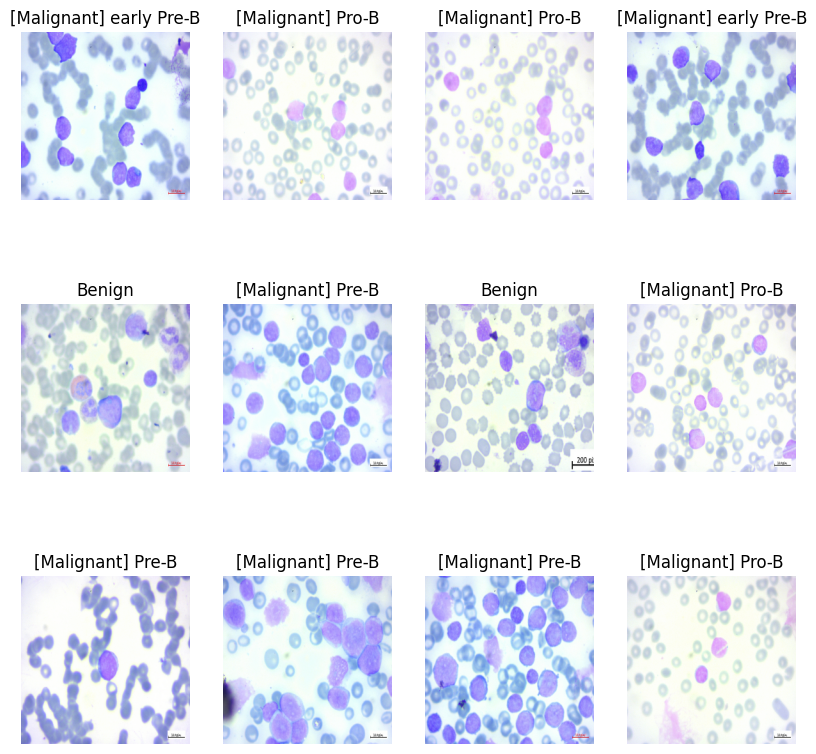

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Spliting Dataset

In [7]:
len(dataset)

102

In [8]:
train_size = 0.8
len(dataset)*train_size

81.60000000000001

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

48

In [11]:
val_size=0.1
len(dataset)*val_size

10.200000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

42

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

81

In [17]:
len(val_ds)

10

In [18]:
len(test_ds)

11

# Data preprocessing

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

### Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



## Building the Model

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 264, 264, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 262, 262, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 131, 131, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 129, 129, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 64, 64, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 62, 62, 64)         

### Compiling the Model

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
81/81 [==============================] - 107s 937ms/step - loss: 1.1064 - accuracy: 0.4891 - val_loss: 0.6629 - val_accuracy: 0.6938
Epoch 2/30
81/81 [==============================] - 72s 887ms/step - loss: 0.5211 - accuracy: 0.7899 - val_loss: 0.5437 - val_accuracy: 0.7500
Epoch 3/30
81/81 [==============================] - 72s 884ms/step - loss: 0.4267 - accuracy: 0.8307 - val_loss: 0.2717 - val_accuracy: 0.9062
Epoch 4/30
81/81 [==============================] - 71s 878ms/step - loss: 0.3783 - accuracy: 0.8537 - val_loss: 0.2410 - val_accuracy: 0.9219
Epoch 5/30
81/81 [==============================] - 72s 887ms/step - loss: 0.3214 - accuracy: 0.8747 - val_loss: 0.2041 - val_accuracy: 0.9156
Epoch 6/30
81/81 [==============================] - 72s 883ms/step - loss: 0.3621 - accuracy: 0.8591 - val_loss: 0.2680 - val_accuracy: 0.8687
Epoch 7/30
81/81 [==============================] - 72s 883ms/step - loss: 0.3151 - accuracy: 0.8817 - val_loss: 0.2327 - val_accuracy: 0.896

In [27]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 6s 187ms/step - loss: 0.1879 - accuracy: 0.9261


In [28]:
scores

[0.18790890276432037, 0.9261363744735718]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 81}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

30

In [36]:
history.history['loss'][:30] # show loss for first 5 epochs

[1.106405258178711,
 0.5210841298103333,
 0.42669677734375,
 0.37826424837112427,
 0.3214428722858429,
 0.362067312002182,
 0.31514620780944824,
 0.29874005913734436,
 0.32785800099372864,
 0.28051307797431946,
 0.31867334246635437,
 0.24096956849098206,
 0.24517393112182617,
 0.2505866289138794,
 0.2034185826778412,
 0.22991618514060974,
 0.21615555882453918,
 0.19738925993442535,
 0.225746288895607,
 0.1790183186531067,
 0.23021100461483002,
 0.2500748634338379,
 0.2132246047258377,
 0.20128686726093292,
 0.20013698935508728,
 0.22411714494228363,
 0.22357648611068726,
 0.199716717004776,
 0.18056535720825195,
 0.1816405951976776]

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

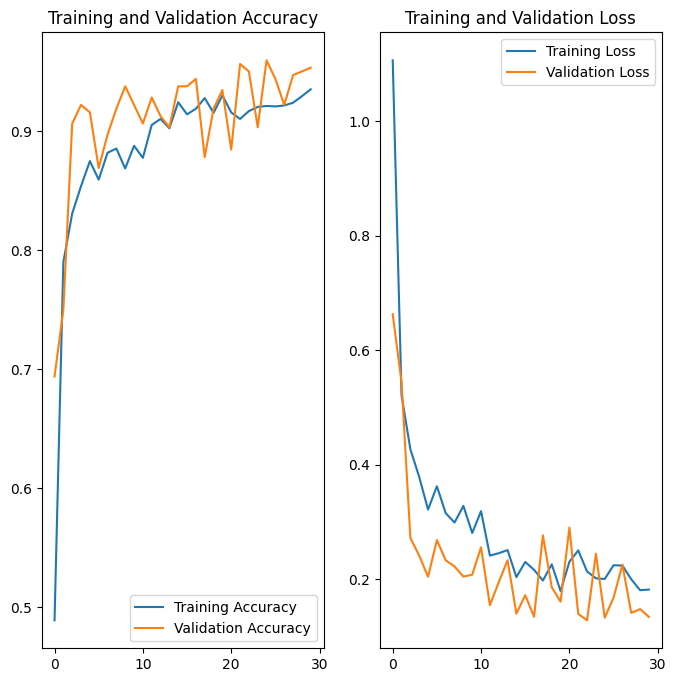

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc[:30], label='Training Accuracy')
plt.plot(range(30), val_acc[:30], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss[:30], label='Training Loss')
plt.plot(range(30), val_loss[:30], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Run prediction on a sample image

first image to predict
actual label: [Malignant] Pre-B
1/1 [==============================] - 0s 300ms/step
predicted label: [Malignant] Pre-B


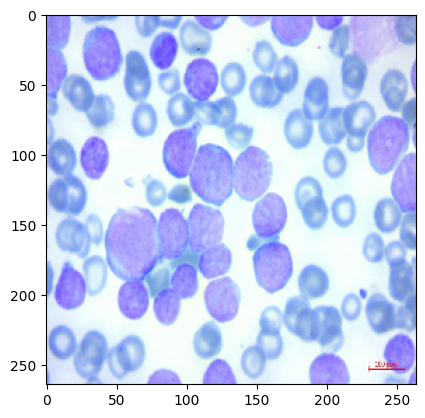

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Saving the Model

In [41]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [42]:
model.save("../leukemia.h5")

C:\Users\shadm\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
